In [1]:
from google.colab import drive
drive.mount('/content/drive')

!nvidia-smi


Mounted at /content/drive
Wed Dec 10 09:38:58 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   60C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+---------------------

In [14]:
import os
import shutil

# Original directories
orig_train = '/content/drive/MyDrive/MRI Images/Training/'
orig_test = '/content/drive/MyDrive/MRI Images/Testing/'

# Working directory
working_dir = '/content/drive/MyDrive/MRI Images/WorkingCopy/'
os.makedirs(working_dir, exist_ok=True)

# New paths
new_train = os.path.join(working_dir, 'Training/')
new_test = os.path.join(working_dir, 'Testing/')

# Copy (only if not already present)
if not os.path.exists(new_train):
    shutil.copytree(orig_train, new_train)
else:
    print("Training folder already exists.")

if not os.path.exists(new_test):
    shutil.copytree(orig_test, new_test)
else:
    print("Testing folder already exists.")

print("Dataset duplicated successfully!")


Training folder already exists.
Testing folder already exists.
Dataset duplicated successfully!


In [2]:
!pip install timm albumentations==1.4.3 opencv-python matplotlib


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.0/137.0 kB 13.0 MB/s eta 0:00:00
  Attempting uninstall: albumentations
    Found existing installation: albumentations 2.0.8
    Uninstalling albumentations-2.0.8:
      Successfully uninstalled albumentations-2.0.8


In [3]:
import os
import shutil
import cv2
import timm
import torch
import numpy as np
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import Dataset, DataLoader
from torch import nn
from tqdm import tqdm


In [5]:
import os

# Use your already-prepared working dataset
dst_root  = "/content/drive/MyDrive/MRI Images/WorkingCopy"
dst_train = f"{dst_root}/Training"
dst_test  = f"{dst_root}/Testing"

# Check if folders exist
if not os.path.exists(dst_train) or not os.path.exists(dst_test):
    print("❌ ERROR: WorkingCopy Training/Testing folders not found!")
else:
    print("✔ Using existing WorkingCopy dataset.")
    print("Training path:", dst_train)
    print("Testing path :", dst_test)


✔ Using existing WorkingCopy dataset.
Training path: /content/drive/MyDrive/MRI Images/WorkingCopy/Training
Testing path : /content/drive/MyDrive/MRI Images/WorkingCopy/Testing


In [4]:
train_transform = A.Compose([
    A.Resize(256, 256),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.3),
    A.RandomBrightnessContrast(p=0.3),
    A.ShiftScaleRotate(shift_limit=0.03, scale_limit=0.05,
                       rotate_limit=10, p=0.4),
    ToTensorV2(),
])

val_transform = A.Compose([
    A.Resize(256, 256),
    ToTensorV2(),
])


In [15]:
class BrainMRIDataset(Dataset):
    def __init__(self, folder, transform=None):
        self.transform = transform
        self.paths = []
        self.labels = []

        classes = sorted(os.listdir(folder))
        self.class_to_idx = {c:i for i,c in enumerate(classes)}

        for c in classes:
            cfolder = os.path.join(folder, c)
            for f in os.listdir(cfolder):
                self.paths.append(os.path.join(cfolder, f))
                self.labels.append(self.class_to_idx[c])

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        img = cv2.imread(self.paths[idx])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        if self.transform:
            img = self.transform(image=img)["image"]

        img = img.float() / 255.0  # normalize to [0,1]

        # IMAGENET normalization
        mean = torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
        std  = torch.tensor([0.229, 0.224, 0.225]).view(3,1,1)
        img = (img - mean) / std

        label = self.labels[idx]
        return img, label


In [16]:
train_dataset = BrainMRIDataset(dst_train, transform=train_transform)
val_dataset   = BrainMRIDataset(dst_test,  transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=32,
                          shuffle=True, num_workers=4,
                          pin_memory=True, persistent_workers=True)

val_loader = DataLoader(val_dataset, batch_size=32,
                        shuffle=False, num_workers=4,
                        pin_memory=True, persistent_workers=True)


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model = timm.create_model("efficientnet_b0",
                          pretrained=True,
                          num_classes=4).to(device)

criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=12)

scaler = torch.cuda.amp.GradScaler()


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

/tmp/ipython-input-407195977.py:11: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


In [15]:
epochs = 15
best_acc = 0

for epoch in range(epochs):
    model.train()
    train_correct = 0
    train_total = 0

    loop = tqdm(train_loader, total=len(train_loader), desc=f"Epoch {epoch+1}/{epochs}")

    for imgs, labels in loop:
        imgs, labels = imgs.to(device), labels.to(device)

        optimizer.zero_grad()

        with torch.cuda.amp.autocast():
            outputs = model(imgs)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        _, preds = outputs.max(1)
        train_correct += preds.eq(labels).sum().item()
        train_total += labels.size(0)

    scheduler.step()
    train_acc = train_correct / train_total

    # ---- Validation ----
    model.eval()
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            out = model(imgs)
            preds = out.argmax(1)
            val_correct += preds.eq(labels).sum().item()
            val_total += labels.size(0)

    val_acc = val_correct / val_total

    print(f"Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")

    if val_acc > best_acc:
        torch.save(model.state_dict(), "best_model_fast.pth")
        best_acc = val_acc


Epoch 1/15:   0%|          | 0/179 [00:00<?, ?it/s]/tmp/ipython-input-4182880593.py:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 1/15: 100%|██████████| 179/179 [07:29<00:00,  2.51s/it]


Train Acc: 0.8202 | Val Acc: 0.9336


Epoch 2/15: 100%|██████████| 179/179 [00:48<00:00,  3.70it/s]


Train Acc: 0.9402 | Val Acc: 0.9756


Epoch 3/15: 100%|██████████| 179/179 [00:48<00:00,  3.66it/s]


Train Acc: 0.9685 | Val Acc: 0.9847


Epoch 4/15: 100%|██████████| 179/179 [00:48<00:00,  3.67it/s]


Train Acc: 0.9836 | Val Acc: 0.9870


Epoch 5/15: 100%|██████████| 179/179 [00:48<00:00,  3.67it/s]


Train Acc: 0.9902 | Val Acc: 0.9939


Epoch 6/15: 100%|██████████| 179/179 [00:48<00:00,  3.69it/s]


Train Acc: 0.9960 | Val Acc: 0.9939


Epoch 7/15: 100%|██████████| 179/179 [00:46<00:00,  3.84it/s]


Train Acc: 0.9944 | Val Acc: 0.9954


Epoch 8/15: 100%|██████████| 179/179 [00:48<00:00,  3.72it/s]


Train Acc: 0.9963 | Val Acc: 0.9954


Epoch 9/15: 100%|██████████| 179/179 [00:47<00:00,  3.73it/s]


Train Acc: 0.9962 | Val Acc: 0.9962


Epoch 10/15: 100%|██████████| 179/179 [00:47<00:00,  3.78it/s]


Train Acc: 0.9972 | Val Acc: 0.9962


Epoch 11/15: 100%|██████████| 179/179 [00:46<00:00,  3.81it/s]


Train Acc: 0.9981 | Val Acc: 0.9969


Epoch 12/15: 100%|██████████| 179/179 [00:47<00:00,  3.78it/s]


Train Acc: 0.9981 | Val Acc: 0.9962


Epoch 13/15: 100%|██████████| 179/179 [00:47<00:00,  3.80it/s]


Train Acc: 0.9983 | Val Acc: 0.9962


Epoch 14/15: 100%|██████████| 179/179 [00:46<00:00,  3.83it/s]


Train Acc: 0.9972 | Val Acc: 0.9962


Epoch 15/15: 100%|██████████| 179/179 [00:46<00:00,  3.83it/s]


Train Acc: 0.9972 | Val Acc: 0.9962


In [16]:
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np
import torch

model.eval()

all_labels = []
all_preds = []
all_probs = []

with torch.no_grad():
    for imgs, labels in val_loader:
        imgs = imgs.to(device)
        outputs = model(imgs)

        probs = torch.softmax(outputs, dim=1).cpu().numpy()
        preds = np.argmax(probs, axis=1)

        all_labels.extend(labels.numpy())
        all_preds.extend(preds)
        all_probs.extend(probs)


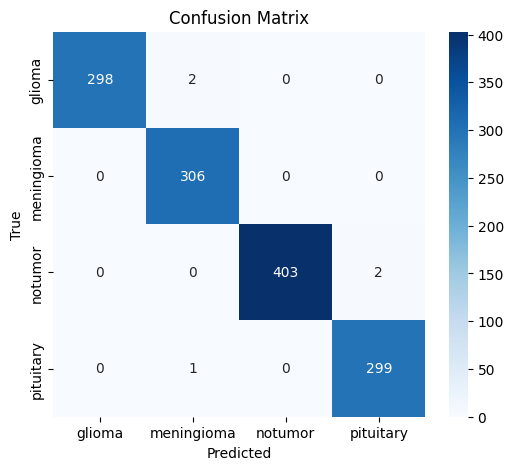

In [17]:
import seaborn as sns

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=train_dataset.class_to_idx.keys(),
            yticklabels=train_dataset.class_to_idx.keys())
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


In [18]:
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=train_dataset.class_to_idx.keys()))



Classification Report:
              precision    recall  f1-score   support

      glioma       1.00      0.99      1.00       300
  meningioma       0.99      1.00      1.00       306
     notumor       1.00      1.00      1.00       405
   pituitary       0.99      1.00      1.00       300

    accuracy                           1.00      1311
   macro avg       1.00      1.00      1.00      1311
weighted avg       1.00      1.00      1.00      1311



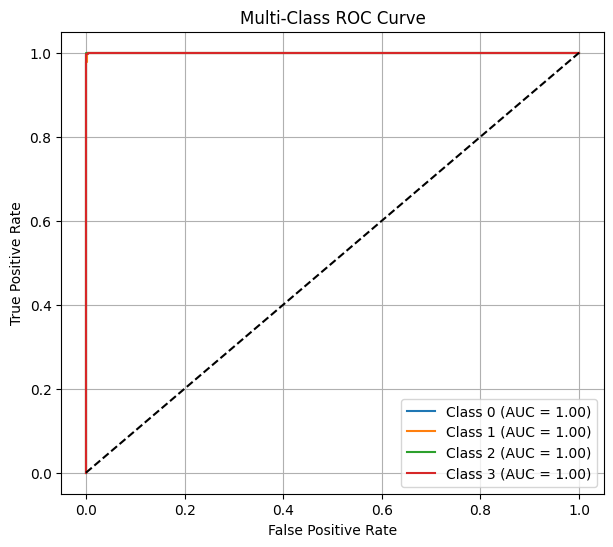

In [19]:
from sklearn.metrics import roc_curve, auc

# Convert labels → one-hot
y_true = label_binarize(all_labels, classes=list(range(4)))
y_score = np.array(all_probs)

fpr = {}
tpr = {}
roc_auc = {}

n_classes = 4

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC
plt.figure(figsize=(7,6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f"Class {i} (AUC = {roc_auc[i]:.2f})")

plt.plot([0,1], [0,1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multi-Class ROC Curve")
plt.legend()
plt.grid()
plt.show()


In [23]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

accuracy = accuracy_score(all_labels, all_preds)
precision_macro = precision_score(all_labels, all_preds, average='macro')
recall_macro = recall_score(all_labels, all_preds, average='macro')
f1_macro = f1_score(all_labels, all_preds, average='macro')

precision_weighted = precision_score(all_labels, all_preds, average='weighted')
recall_weighted = recall_score(all_labels, all_preds, average='weighted')
f1_weighted = f1_score(all_labels, all_preds, average='weighted')


print(f" Accuracy    : {accuracy:.4f}")
print(f" Precision   : {precision_macro:.4f}")
print(f" Recall      : {recall_macro:.4f}")
print(f" F1 Score    : {f1_macro:.4f}\n")



 Accuracy    : 0.9962
 Precision   : 0.9959
 Recall      : 0.9963
 F1 Score    : 0.9961



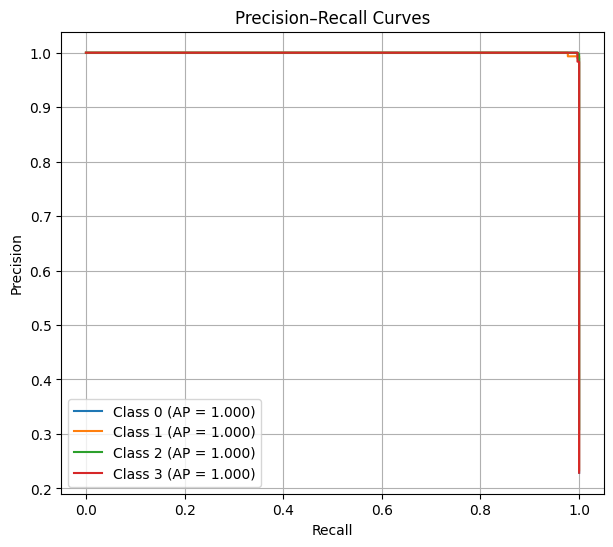

In [24]:
from sklearn.metrics import precision_recall_curve, average_precision_score

plt.figure(figsize=(7,6))

for i in range(n_classes):
    precision, recall, _ = precision_recall_curve(y_true[:, i], y_score[:, i])
    ap = average_precision_score(y_true[:, i], y_score[:, i])

    plt.plot(recall, precision, label=f"Class {i} (AP = {ap:.3f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curves")
plt.legend()
plt.grid()
plt.show()


In [26]:
!mkdir -p "/content/drive/MyDrive/MRI Images/Models"


In [27]:
import torch

save_path = "/content/drive/MyDrive/MRI Images/Models/best_model_fast.pth"
torch.save(model.state_dict(), save_path)

print(f"✔ Model saved successfully to: {save_path}")


✔ Model saved successfully to: /content/drive/MyDrive/MRI Images/Models/best_model_fast.pth


In [17]:
import torch
import timm

device = "cuda" if torch.cuda.is_available() else "cpu"

model = timm.create_model("efficientnet_b0", pretrained=False, num_classes=4)
model.load_state_dict(torch.load("/content/drive/MyDrive/MRI Images/Models/best_model_fast.pth", map_location=device))
model.to(device)
model.eval()

print("✔ Model loaded successfully from Drive")


✔ Model loaded successfully from Drive


In [18]:
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt

# GradCAM class
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer

        self.gradients = None
        self.activations = None

        target_layer.register_forward_hook(self.save_activation)
        target_layer.register_backward_hook(self.save_gradient)

    def save_activation(self, module, inp, out):
        self.activations = out.detach()

    def save_gradient(self, module, grad_in, grad_out):
        self.gradients = grad_out[0].detach()

    def generate(self, input_tensor, class_idx=None):
        output = self.model(input_tensor)

        if class_idx is None:
            class_idx = output.argmax(1).item()

        self.model.zero_grad()
        output[0, class_idx].backward()

        gradients = self.gradients.mean(dim=[2, 3], keepdim=True)
        cam = (gradients * self.activations).sum(dim=1).squeeze()

        cam = torch.relu(cam)
        cam = cam.cpu().numpy()
        cam = cv2.resize(cam, (256, 256))
        cam = (cam - cam.min()) / (cam.max() + 1e-8)

        return cam


In [19]:
# LAST convolution layer of EfficientNet-B0
target_layer = model.conv_head

cam = GradCAM(model, target_layer)


In [20]:
class_names = list(train_dataset.class_to_idx.keys())
print("Class mapping:", class_names)

Class mapping: ['glioma', 'meningioma', 'notumor', 'pituitary']


In [21]:
import torch.nn.functional as F

def show_gradcam(image_path):

    img = cv2.imread(image_path)
    if img is None:
        print("❌ Image not found:", image_path)
        return

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    raw = cv2.resize(img, (256,256))

    # --- Preprocess same as validation ---
    processed = val_transform(image=raw)["image"].float() / 255.0

    mean = torch.tensor([0.485,0.456,0.406]).view(3,1,1)
    std  = torch.tensor([0.229,0.224,0.225]).view(3,1,1)

    processed = (processed - mean) / std
    processed = processed.unsqueeze(0).to(device)

    # ----- MODEL PREDICTION -----
    model.eval()
    with torch.no_grad():
        outputs = model(processed)
        probs = F.softmax(outputs, dim=1)
        pred_idx = probs.argmax(1).item()
        pred_class = class_names[pred_idx]
        confidence = probs[0][pred_idx].item() * 100

    # ---- GRAD-CAM ----
    heatmap = cam.generate(processed)

    heatmap_color = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
    heatmap_color = cv2.cvtColor(heatmap_color, cv2.COLOR_BGR2RGB)

    blended = cv2.addWeighted(raw, 0.5, heatmap_color, 0.5, 0)

    # ---- VISUALIZATION ----
    plt.figure(figsize=(13,6))

    plt.suptitle(
        f"Prediction: {pred_class.upper()}  |  Confidence: {confidence:.2f}%",
        fontsize=16, fontweight='bold'
    )

    plt.subplot(1,3,1)
    plt.title("Original MRI")
    plt.imshow(raw)
    plt.axis("off")

    plt.subplot(1,3,2)
    plt.title("Grad-CAM Heatmap")
    plt.imshow(heatmap_color)
    plt.axis("off")

    plt.subplot(1,3,3)
    plt.title("Overlay (Tumor Region Highlighted)")
    plt.imshow(blended)
    plt.axis("off")

    plt.show()

    print(f"✔ Predicted Class: {pred_class}")
    print(f"✔ Confidence: {confidence:.2f}%")


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1866: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


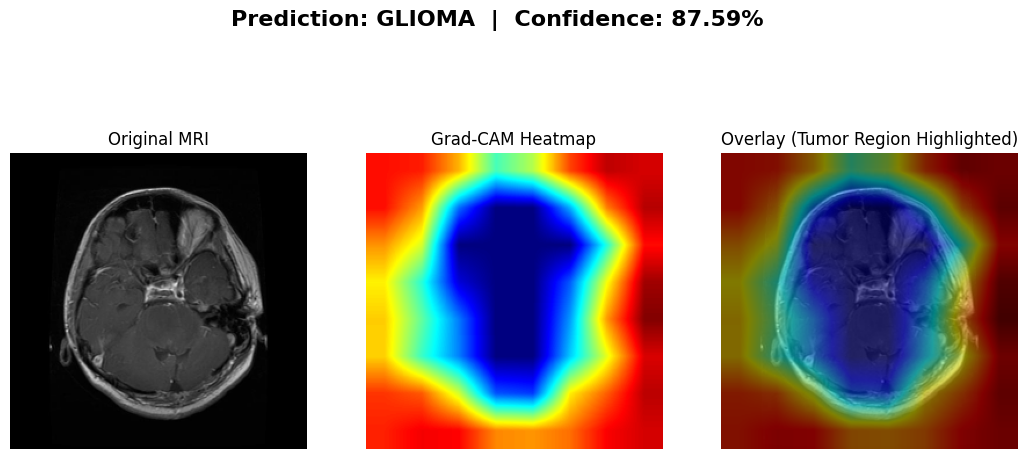

✔ Predicted Class: glioma
✔ Confidence: 87.59%


In [22]:
show_gradcam("/content/drive/MyDrive/MRI Images/WorkingCopy/Testing/glioma/Te-gl_0010.jpg")


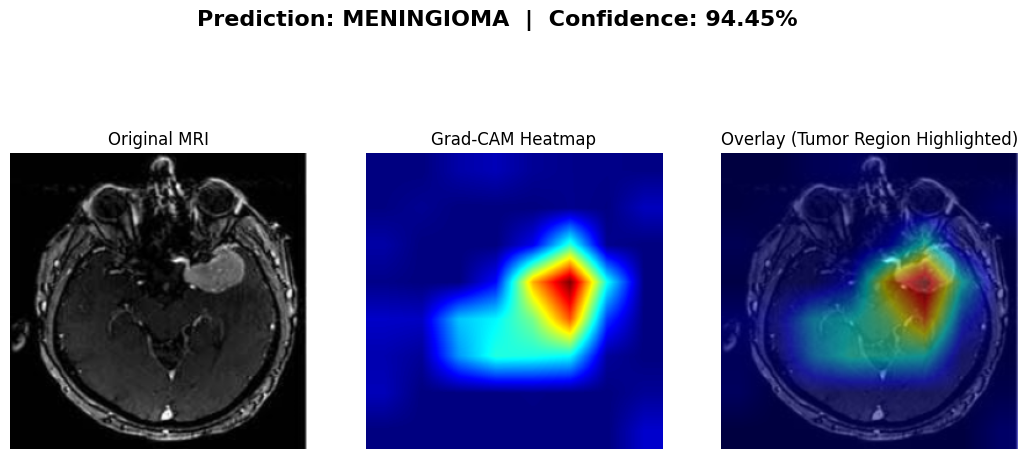

✔ Predicted Class: meningioma
✔ Confidence: 94.45%


In [28]:
show_gradcam("/content/drive/MyDrive/MRI Images/WorkingCopy/Testing/meningioma/Te-me_0011.jpg")


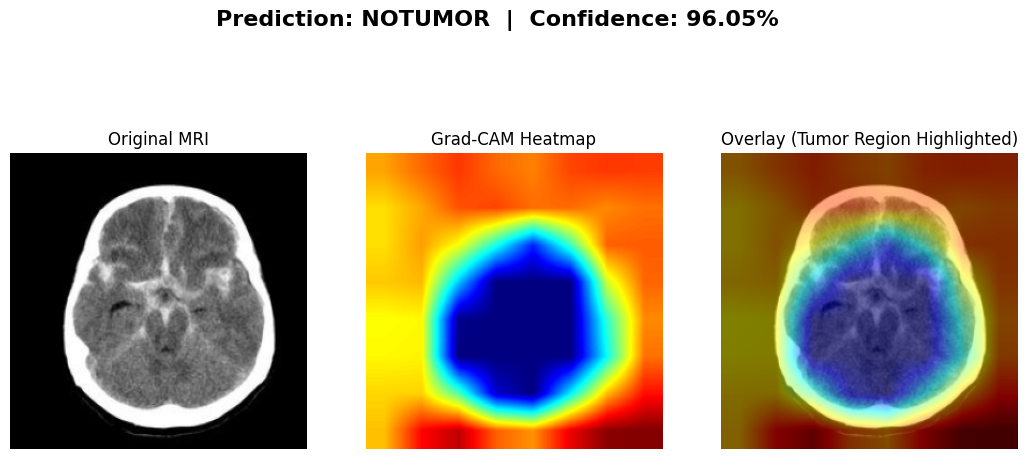

✔ Predicted Class: notumor
✔ Confidence: 96.05%


In [29]:
show_gradcam("/content/drive/MyDrive/MRI Images/WorkingCopy/Testing/notumor/Te-no_0011.jpg")

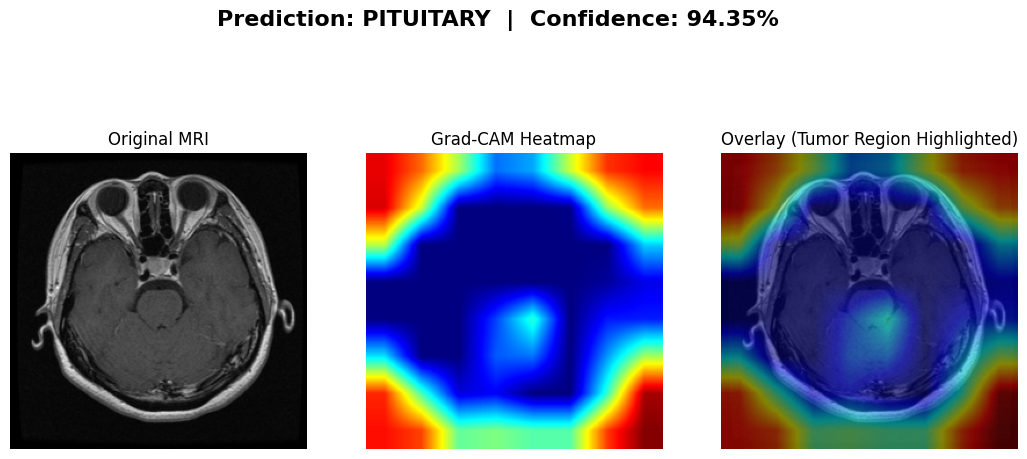

✔ Predicted Class: pituitary
✔ Confidence: 94.35%


In [30]:
show_gradcam("/content/drive/MyDrive/MRI Images/WorkingCopy/Testing/pituitary/Te-pi_0011.jpg")

In [31]:
!pip install gradio timm opencv-python albumentations==1.4.3

import gradio as gr
import torch
import timm
import cv2
import numpy as np
import albumentations as A
from albumentations.pytorch import ToTensorV2
import os

# ---- Device ----
device = "cuda" if torch.cuda.is_available() else "cpu"

# ---- Model ----
model = timm.create_model("efficientnet_b0", pretrained=True, num_classes=4)
model.load_state_dict(torch.load(
    "/content/drive/MyDrive/MRI Images/WorkingCopy/best_model_fast.pth",
    map_location=device
))
model.to(device)
model.eval()

# ---- Dataset Info ----
dst_test = "/content/drive/MyDrive/MRI Images/WorkingCopy/Testing"
class_names = sorted(os.listdir(dst_test))

# ---- Validation Transform ----
val_transform = A.Compose([
    A.Resize(256, 256),
    ToTensorV2(),
])

# ---- GradCAM Helper ----
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self.hook_layers()

    def hook_layers(self):
        def forward_hook(module, input, output):
            self.activations = output.detach()
        def backward_hook(module, grad_in, grad_out):
            self.gradients = grad_out[0].detach()
        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_backward_hook(backward_hook)

    def generate(self, x):
        self.model.zero_grad()
        out = self.model(x)
        pred_class = out.argmax(dim=1)
        loss = out[:, pred_class]
        loss.backward(retain_graph=True)

        weights = self.gradients.mean(dim=(2,3), keepdim=True)
        cam = torch.relu((weights * self.activations).sum(1, keepdim=True))
        cam = torch.nn.functional.interpolate(cam, size=(256,256), mode='bilinear', align_corners=False)
        cam = cam[0,0].cpu().numpy()
        cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)
        return cam

# Attach GradCAM to the last convolutional layer of EfficientNet-B0
cam = GradCAM(model, model.conv_head)

# ---- Prediction Function ----
def predict_with_gradcam(image):
    """
    image: numpy array from user upload
    Returns: predicted class, probabilities, original image, GradCAM heatmap
    """
    # Convert BGR to RGB
    img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    raw = cv2.resize(img, (256,256))

    # Apply transform
    processed = val_transform(image=raw)["image"].float() / 255.0

    # Normalize
    mean = torch.tensor([0.485,0.456,0.406]).view(3,1,1)
    std  = torch.tensor([0.229,0.224,0.225]).view(3,1,1)
    processed = (processed - mean) / std

    # Move to device
    processed = processed.unsqueeze(0).to(device)

    # ---- Prediction ----
    with torch.no_grad():
        out = model(processed)
        probs = torch.softmax(out, dim=1)[0].cpu().numpy()
    pred_idx = np.argmax(probs)
    prediction = class_names[pred_idx]

    # ---- GradCAM ----
    heatmap = cam.generate(processed)
    heatmap_color = cv2.applyColorMap(np.uint8(255*heatmap), cv2.COLORMAP_JET)
    heatmap_color = cv2.cvtColor(heatmap_color, cv2.COLOR_BGR2RGB)
    blended = cv2.addWeighted(raw, 0.5, heatmap_color, 0.5, 0)

    return (
        prediction,
        {class_names[i]: float(probs[i]) for i in range(len(class_names))},
        raw,
        blended
    )

# ---- Gradio UI ----
ui = gr.Interface(
    fn=predict_with_gradcam,
    inputs=gr.Image(type="numpy", label="Upload MRI Image"),
    outputs=[
        gr.Label(label="Predicted Tumor Type"),
        gr.Label(label="Class Probabilities"),
        gr.Image(label="Original Image"),
        gr.Image(label="GradCAM Heatmap")
    ],
    title="Brain Tumor Classification (EfficientNet-B0 + GradCAM)",
    description="Upload a brain MRI image to classify tumor type and visualize model explanation using GradCAM."
)

ui.launch(debug=True)



It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://aa90885d30237ea24e.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


ERROR:    Exception in ASGI application
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/uvicorn/protocols/http/h11_impl.py", line 403, in run_asgi
    result = await app(  # type: ignore[func-returns-value]
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/uvicorn/middleware/proxy_headers.py", line 60, in __call__
    return await self.app(scope, receive, send)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/fastapi/applications.py", line 1133, in __call__
    await super().__call__(scope, receive, send)
  File "/usr/local/lib/python3.12/dist-packages/starlette/applications.py", line 113, in __call__
    await self.middleware_stack(scope, receive, send)
  File "/usr/local/lib/python3.12/dist-packages/starlette/middleware/errors.py", line 186, in __call__
    raise exc
  File "/usr/local/lib/python3.12/dist-packages/starlette/middleware/errors.py",

Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://aa90885d30237ea24e.gradio.live
